# Random Forests - Affairs

We are going to look at our affairs dataset again, to run a random forest model. This allows us to compare the outcome of a random forest classifier to the earlier used logistic regression model on the same data.

In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import pylab
import scipy.stats as stats
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline 
mpl.style.available
mpl.style.use('ggplot') 

## Data 

We'll work with the affairs dataset again for this. We can compare results and see whether the Random Forest clasifier does better than our logistic regression model. Remember that the data consists of:

Number of observations: 6366

Number of variables: 9

Variable name definitions:

    rate_marriage   : How rate marriage, 1 = very poor, 2 = poor, 3 = fair,
                    4 = good, 5 = very good
    age             : Age
    yrs_married     : No. years married. Interval approximations. See
                    original paper for detailed explanation.
    children        : No. children
    religious       : How relgious, 1 = not, 2 = mildly, 3 = fairly,
                    4 = strongly
    educ            : Level of education, 9 = grade school, 12 = high
                    school, 14 = some college, 16 = college graduate,
                    17 = some graduate school, 20 = advanced degree
    occupation      : 1 = student, 2 = farming, agriculture; semi-skilled,
                    or unskilled worker; 3 = white-collar; 4 = teacher
                    counselor social worker, nurse; artist, writers;
                    technician, skilled worker, 5 = managerial,
                    administrative, business, 6 = professional with
                    advanced degree
    occupation_husb : Husband's occupation. Same as occupation.
    affairs         : measure of time spent in extramarital affairs
    
 

Let's load the data again, and we'll treat it exactly the same as in the logistic regression model. 

In [2]:
df = sm.datasets.fair.load_pandas().data
df.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666


We'll quickly create our affair target variable again, and use Patsy dmatrices to pre-treat our data. 

In [3]:
df['affair']=df['affairs'].map(lambda x: 1 if x>0 else 0)

y, X = dmatrices('affair ~ rate_marriage + age + yrs_married + children + religious + \
                   C(educ) + C(occupation) + C(occupation_husb)',
                  df, return_type="dataframe")
y=np.ravel(y)
header = X.columns

Let's check whether we're still dealing with the same distribution of affairs in the dataset.

0    4313
1    2053
Name: affair, dtype: int64


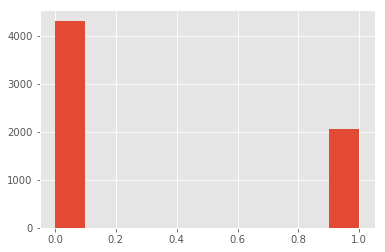

In [4]:
df.affair.hist()
print (df.affair.value_counts())

Yep that seems all ok. Let's dive right in with the Random Forest classification, this should look somewhat familiar by now. We'll start by splitting our data into test and training data.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [6]:
model = RandomForestClassifier(n_estimators=5)
model.fit(X_train, y_train)

predicted = model.predict(X_test)
probs = model.predict_proba(X_test)

print (metrics.accuracy_score(y_test, predicted))
print (metrics.roc_auc_score(y_test, probs[:, 1]))
print (classification_report(y_test, predicted))

0.66335078534
0.65838433927
             precision    recall  f1-score   support

        0.0       0.75      0.77      0.76      1303
        1.0       0.47      0.44      0.45       607

avg / total       0.66      0.66      0.66      1910



Boo! that does not look great, let's refresh your memory to see how we did with a logistic regression model.

In [7]:
model = LogisticRegression()
model.fit(X_train, y_train)
predicted = model.predict(X_test)
probs = model.predict_proba(X_test)
print (metrics.accuracy_score(y_test, predicted))
print (metrics.roc_auc_score(y_test, probs[:, 1]))
print (classification_report(y_test, predicted))

0.728795811518
0.745315903864
             precision    recall  f1-score   support

        0.0       0.75      0.89      0.82      1303
        1.0       0.62      0.38      0.47       607

avg / total       0.71      0.73      0.71      1910



Yep that was slightly better indeed, so how can we tweak our Random Forest to make it predict better? Well there are a few parameters we can play with. The proper way to do it, would be to do a 3 way split of data, one training set, one validation set for the right parameter value, and one test set. Let's keep it easy for now and let's play around with it manually. Let's start by calculating what I'd like to call our "baseline" accuracy score. It's basically the percentage of predictions that are correct, if you always assume someone is a 0, i.e. does not have an affair. Our model needs to do at least better than this to be valuable.

In [8]:
# percentage tells you how much predicition you would get if you always predict a zero outcome (i.e. the division of 0 versus 1 outcomes)

len_y=len(y)
temp=[i for i in y if i==0]
temp_1=temp.count(0)

percentage = float(temp_1)/float(len_y)
print (percentage *100)

67.75054979579014


Now we can play with that "number of estimators" parameter. It basically tells the RF Classifier the number of trees to use. In general, the more trees you use the better the results get. However, the improvement decreases as the number of trees increases, i.e. at a certain point the benefit in prediction performance from learning more trees will be lower than the cost in computation time for learning these additional trees. 
 
Let's have it range from 1 to 40, and let's see whether our model accuracy gets any better when it increases. Mind you, the code will run fairly slow, as 40 is already quite a lot.  

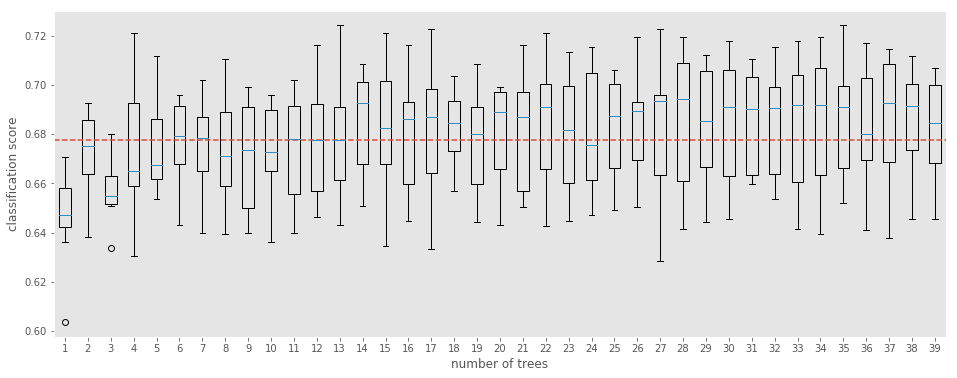

In [9]:
scores=[]
for val in range (1,40):
    clf=RandomForestClassifier(n_estimators=val)
    validated=cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    scores.append(validated)

fig, axes = plt.subplots(figsize=(16,6))
bp = plt.boxplot(scores)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='o')
plt.axhline(y=percentage, ls='--')
plt.xlabel('number of trees')
plt.ylabel('classification score')
plt.grid()

Let's take some time to interpret this graph and make sure you understand what's going on here. Each boxplot on the graph is a collection of accuracy score outcomes from a 10-fold cross validation from a RF model with x amount of trees, where x ranges from 1 to 40 along the x-axis. OK, that's a complex sentence... make sure you understood. 

Now from the graph above you can see that we improve from 1 to 10 trees, but after that, there is only a slight improvement. It's fair to say that the mean of the accuracy score is higher on the right side of the graph, than on the left, but you can see that increasing your model by a lot of trees does not necessarily make it much better after some point. 

If you want to learn more about which settings we can tweak in the RF model, I can recommend you to have a look here:
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html



Now we have seen that the RF does not necessarily do better than our much simpler Logistic Regression. Why is this? Well, in a nutshell, if there is a strong correlation in the underlying data (and that's the case for some features, as we saw in the logistic regression notebook) then our logistic regression model can do a great job of fitting the data. The RF model in this case is just a bit overcomplex and probably tries to overfit. Also, with Random Forests, the accuracy depends a lot on the data presented. For example, trees can become biased towards a specific class if it occurs a lot, or become "confused" when trying to fit certain rules inferred from the data. 

I found an excellent source for helping you choose your model, a problem many data scientist face often, here:

https://www.quora.com/What-are-the-advantages-of-different-classification-algorithms

The first answer really covers it all and should give you some guidance on what model to choose.

### Interpreting the Random Forest: Feature importance 

Most literature on random forests and interpretable models would lead you to believe interpretation is nigh impossible, since random forests are typically treated as a black box. Indeed, a forest consists of a large number of deep trees, where each tree is trained on bagged data using random selection of features, so gaining a full understanding of the decision process by examining each individual tree is infeasible. Furthermore, even if we are to examine just a single tree, it is only feasible in the case where it has a small depth and low number of features. A tree of depth 10 can already have thousands of nodes, meaning that using it as an explanatory model is almost impossible.

One way of getting an insight into a random forest is to compute feature importances, either by permuting the values of each feature one by one and checking how it changes the model performance, or computing the amount of “impurity” (typically variance in case of regression trees and gini coefficient or entropy in case of classification trees) each feature removes when it is used in a node. Both approaches are useful, but crude and static in the sense that they give little insight in understanding individual decisions on actual data. Nonetheless, here is an example of how to calculate and plot it.

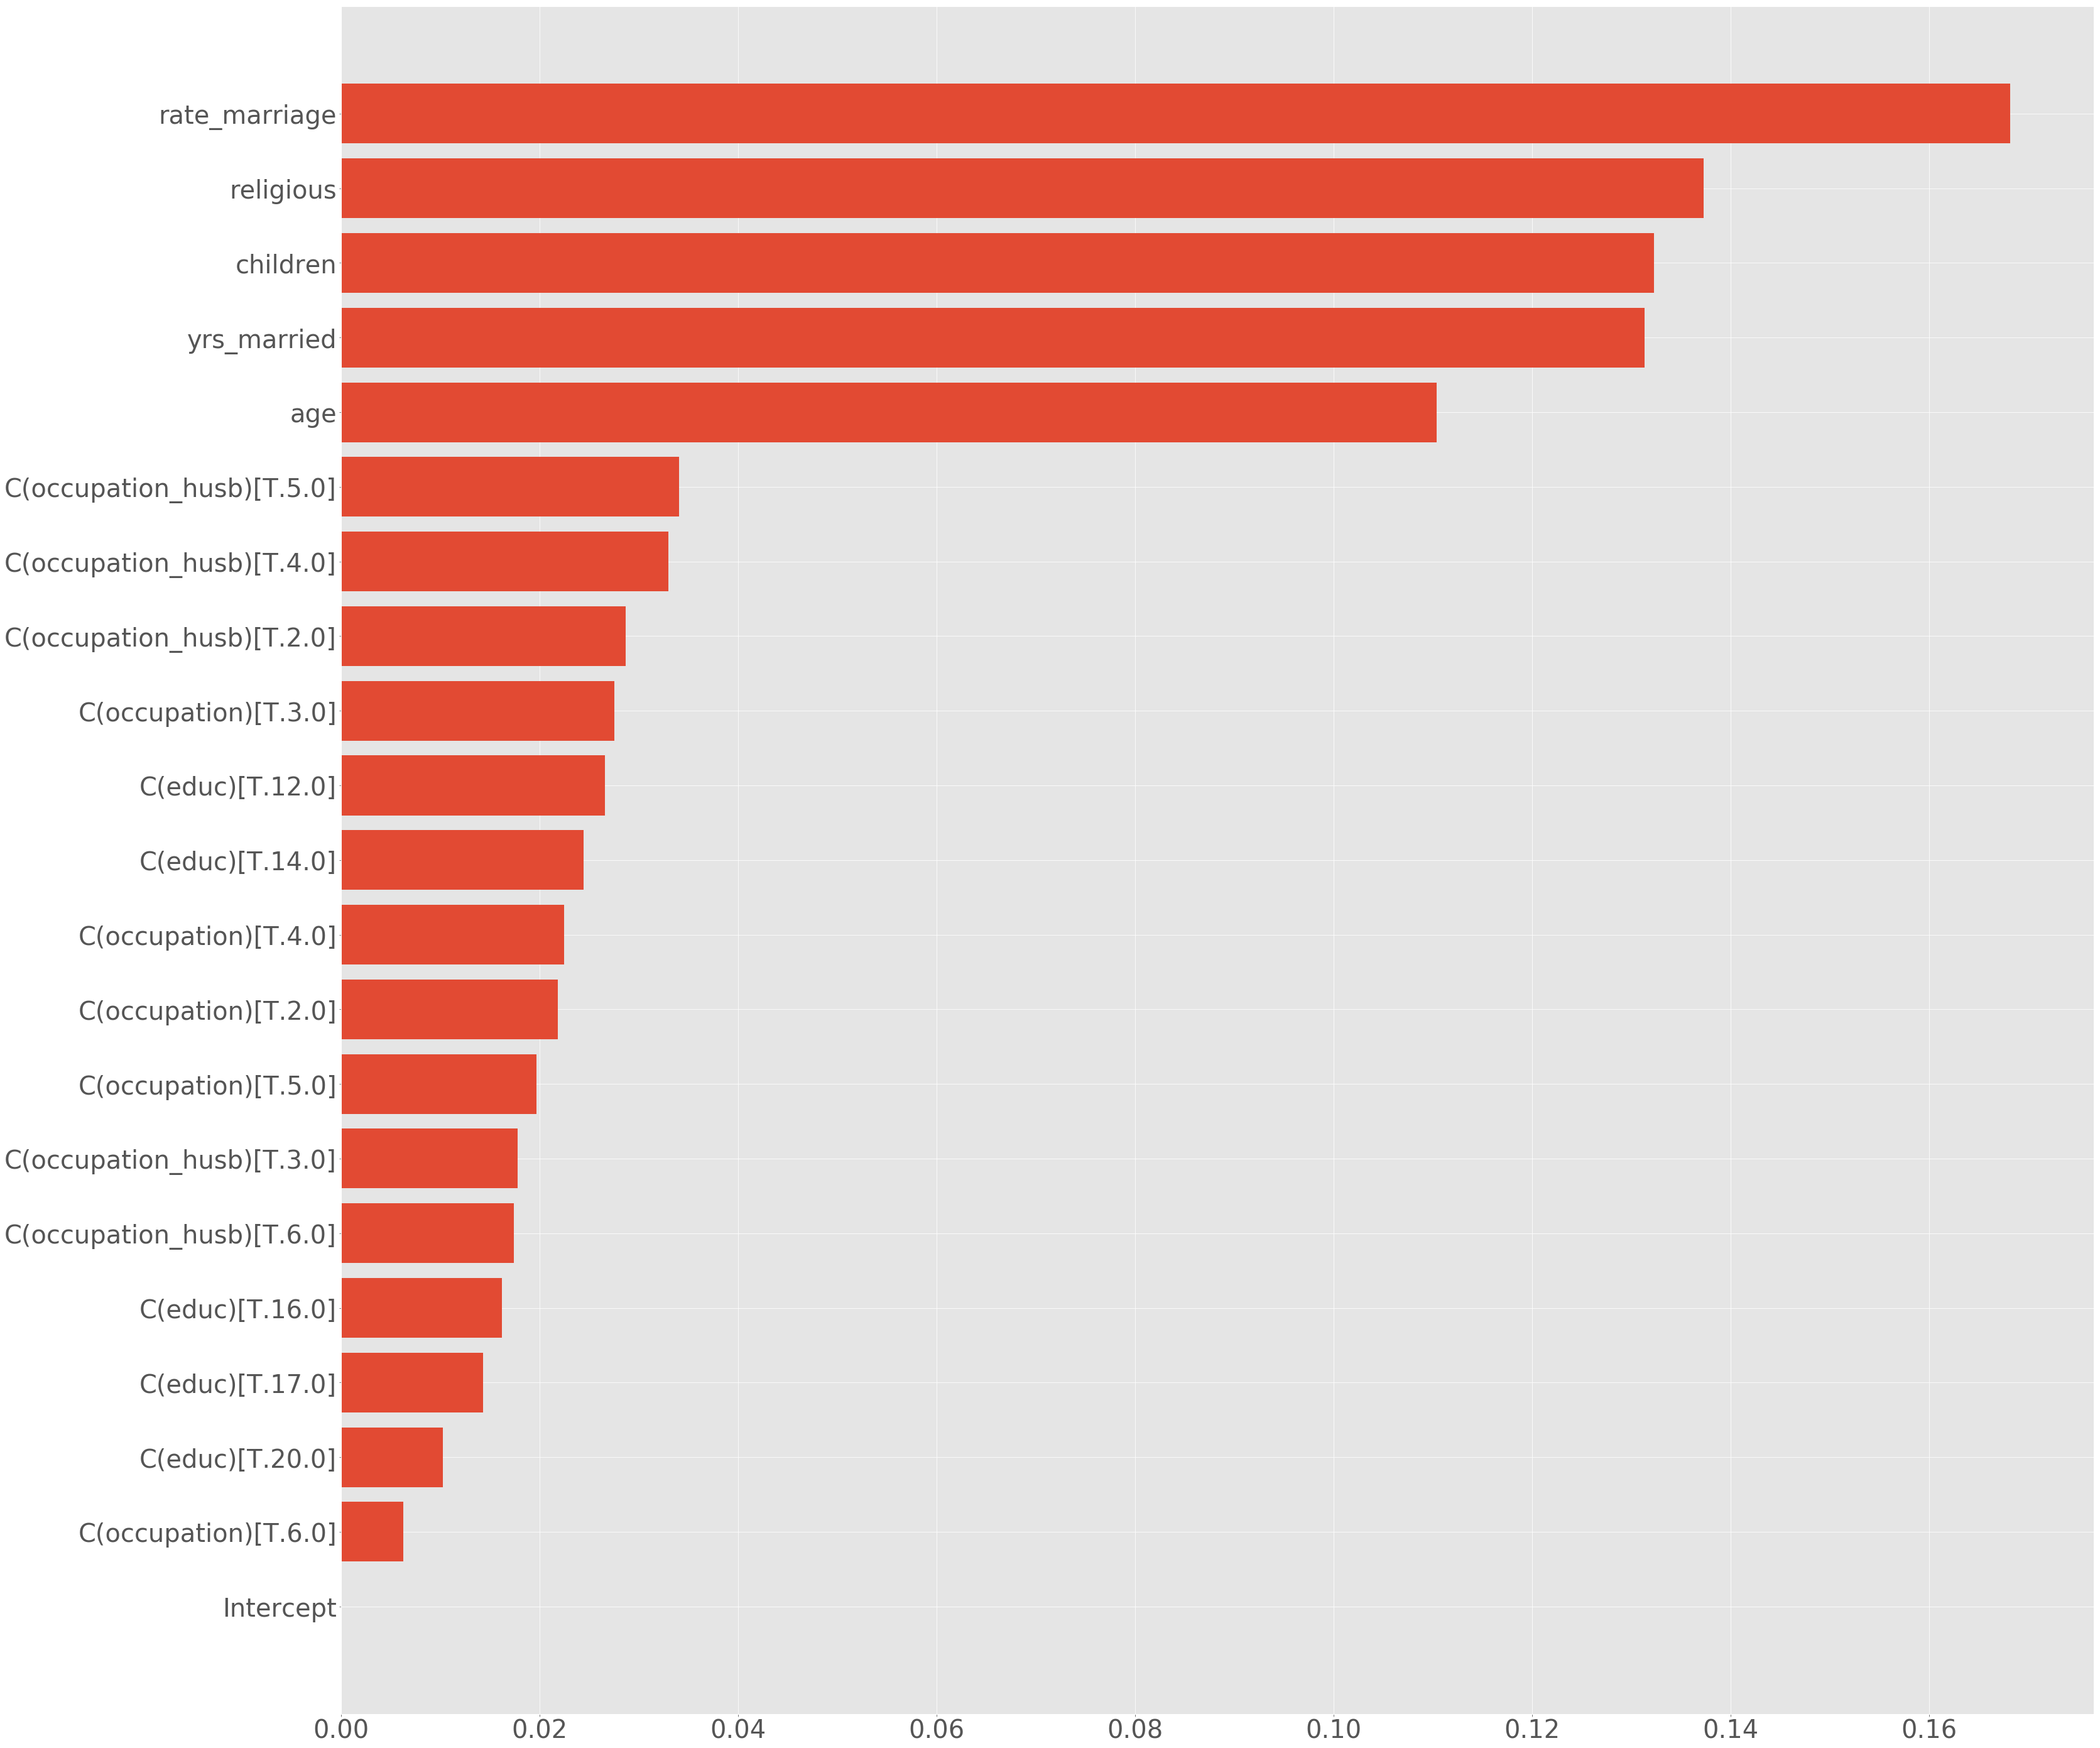

In [10]:
# calculate the importances and zip the names of features to it
model = RandomForestClassifier(n_estimators=10)
model.fit(X_train, y_train)
imp=model.feature_importances_
imp,names=zip(*sorted(zip(imp, header)))

# now let's put it in a chart
plt.figure(figsize=(50,50))
plt.barh(range(len(names)), imp, align='center')
plt.yticks(range(len(names)), names, fontsize=40)
plt.xticks(fontsize=40)
plt.show()

Another way of interpreting the RF model is to use a library written by a guy called Ando Saabas who has a blog on machine learning and works for Microsoft. He claims that with his code interpreting the actual random forest model is straightforward. It's called the treeinterpreter (`pip install treeinterpreter`) library and can decompose scikit-learn‘s decision tree and random forest model predictions. More information and examples available here:

http://blog.datadive.net/random-forest-interpretation-with-scikit-learn/

Copyright © SherlockML 2017 All rights reserved